In [1]:
import os
import re
import sys
import gzip
import json
import codecs
import pyBigWig
import numpy as np
from pyfaidx import Fasta
from scipy.stats import spearmanr, pearsonr, gaussian_kde
from matplotlib import pyplot as plt
from scipy.stats import percentileofscore
%matplotlib inline

In [2]:
flankToCbf1Ddg = {}
flankToPho4Ddg = {}
firstLine = True
with open("data/experimental/all_predicted_ddGs.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flank, Cbf1_ddg, Pho4_ddg = line.strip().split(',')
        flankToCbf1Ddg[flank] = float(Cbf1_ddg)
        flankToPho4Ddg[flank] = float(Pho4_ddg)

In [3]:
tfToDeltaCountsDict = {}
tfToDeltaCountsDict["pho4_120m"] = json.loads(codecs.open("data/preds/pho4_120min_nexus_1.json", 'r', encoding='utf-8').read())
tfToDeltaCountsDict["pho4_30m"] = json.loads(codecs.open("data/preds/pho4_120min_nexus_1.json", 'r', encoding='utf-8').read())
tfToDeltaCountsDict["pho4_pbexo"] = json.loads(codecs.open("data/preds/pbexo.pho4.flankToDeltaLogCount.json", 'r', encoding='utf-8').read())

In [4]:
tfToBigWigs = {}
tfToBigWigs["pho4_120m"] = (pyBigWig.open("data/nexus/120min/sc_myc_PHO4_120min_nexus_1_positive.bw"),
                           pyBigWig.open("data/nexus/120min/sc_myc_PHO4_120min_nexus_1_negative.bw"))
tfToBigWigs["pho4_30m"] = (pyBigWig.open("data/nexus/30min/sc_myc_PHO4_30min_nexus_1_positive.bw"),
                       pyBigWig.open("data/nexus/30min/sc_myc_PHO4_30min_nexus_1_negative.bw"))
tfToBigWigs["pho4_pbexo"] = (pyBigWig.open("data/pho4_pbexo/basename_prefix.pooled.positive.bigwig"),
                       pyBigWig.open("data/pho4_pbexo/basename_prefix.pooled.negative.bigwig"))

In [5]:
tfToBeds = {}
tfToBeds["pho4_120m"] = open("data/nexus/120min/sc_myc_PHO4_120min_nexus_1_peaks.narrowPeak")
tfToBeds["pho4_30m"] = open("data/nexus/30min/sc_myc_PHO4_30min_nexus_1_peaks.narrowPeak")
tfToBeds["pho4_pbexo"] = open("data/pho4_pbexo/pho4.pbexo.bed")

In [6]:
chrms = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII",
         "chrIX","chrX","chrXI","chrXII","chrXIII","chrXIV","chrXV","chrXVI","chrM"]

In [7]:
fastapath = "data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [8]:
motif = "CACGTG"
motifLen = len(motif)
flankLen = 5
genomeFlankToCoord = {}
for chrm in chrms:
    sequence = GenomeDict[chrm].upper()
    for m in re.finditer(motif, sequence):
        flank = GenomeDict[chrm][m.start()-flankLen:m.start()]+ \
                GenomeDict[chrm][m.start()+motifLen:m.start()+motifLen+flankLen]
        if flank not in genomeFlankToCoord:
            genomeFlankToCoord[flank] = []
        genomeFlankToCoord[flank].append((chrm, m.start()+(motifLen/2)))

In [9]:
seq_len = 500
keyToFlankToCoord = {}
keyToFlankToCoord["pho4_120m"] = {}
keyToFlankToCoord["pho4_30m"] = {}
keyToFlankToCoord["pho4_pbexo"] = {}
for key in tfToBeds:
    for line in tfToBeds[key]:
        peakChrm = line.strip().split('\t')[0]
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 1
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        for flank in genomeFlankToCoord:
            for chrm, center in genomeFlankToCoord[flank]:
                if chrm == peakChrm and center >= start and center <= end:
                    if flank not in keyToFlankToCoord[key]:
                        keyToFlankToCoord[key][flank] = []
                    keyToFlankToCoord[key][flank].append((chrm, center))

pho4_120m


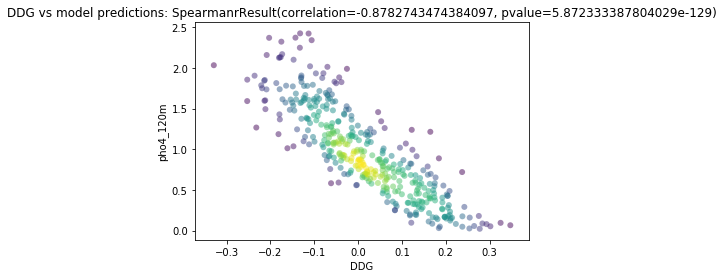

pho4_30m


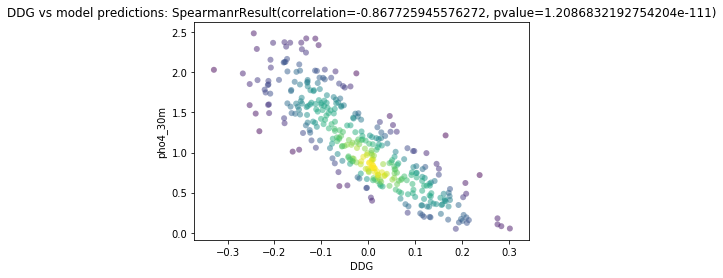

pho4_pbexo


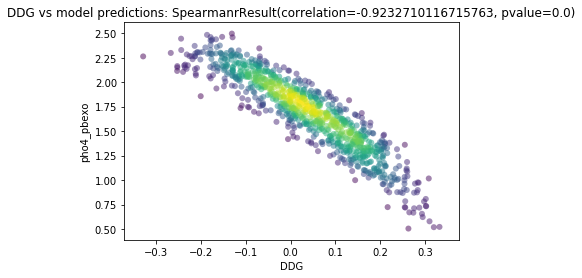

In [10]:
for key in tfToDeltaCountsDict.keys():
    print(key)
    yvals = []
    for flank in keyToFlankToCoord[key]:
        y_0 = np.array(tfToDeltaCountsDict[key][flank][0]).astype(float)
        y_1 = np.array(tfToDeltaCountsDict[key][flank][1]).astype(float)
        yvals.append(np.mean(y_1-y_0))
    xvals_pho4 = []
    xvals_cbf1 = []
    for flank in keyToFlankToCoord[key]:
        xvals_pho4.append(flankToPho4Ddg[flank])
        xvals_cbf1.append(flankToCbf1Ddg[flank])
    if "pho4" in key:
        xvals = xvals_pho4
    elif "cbf1" in key:
        xvals = xvals_cbf1
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
    plt.xlabel("DDG")
    plt.ylabel(key)
    plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
    plt.show()

In [11]:
seq_len = 546
posFootprint = {}
negFootprint = {}
for key in tfToBigWigs.keys():
    posFootprint[key] = {}
    negFootprint[key] = {}
    for flank in keyToFlankToCoord[key]:
        currentPosCounts= []
        currentNegCounts = []
        for chrm, center in keyToFlankToCoord[key][flank]: 
            start = int(center-(seq_len/2))
            end = int(center+(seq_len/2))
            posvals = np.array(tfToBigWigs[key][0].values(chrm, start, end))
            where_are_NaNs = np.isnan(posvals)
            posvals[where_are_NaNs] = 0.0
            currentPosCounts.append(posvals)
            negvals = np.array(tfToBigWigs[key][1].values(chrm, start, end))
            where_are_NaNs = np.isnan(negvals)
            negvals[where_are_NaNs] = 0.0
            currentNegCounts.append(negvals)
        posFootprint[key][flank] = np.mean(np.array(currentPosCounts), axis = 0)
        negFootprint[key][flank] = np.mean(np.array(currentNegCounts), axis = 0)

16
pho4_120m


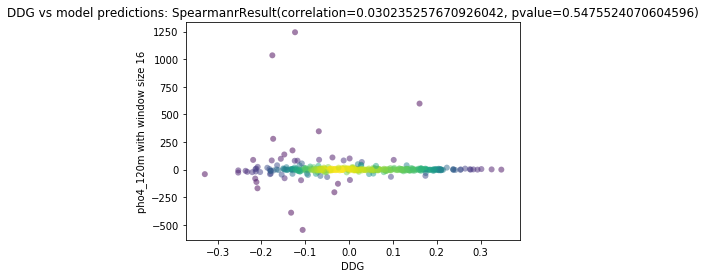

pho4_30m


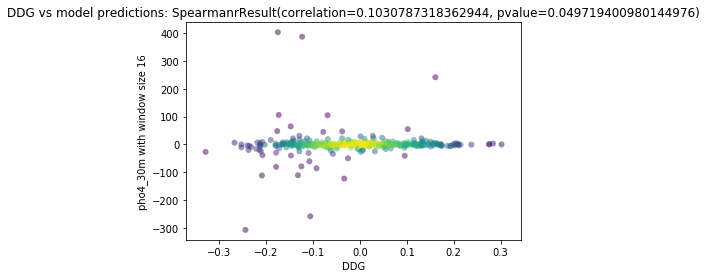

pho4_pbexo


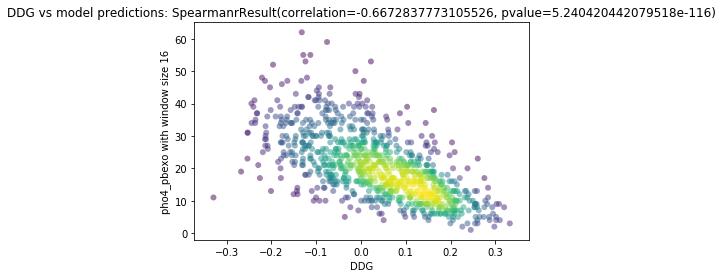

32
pho4_120m


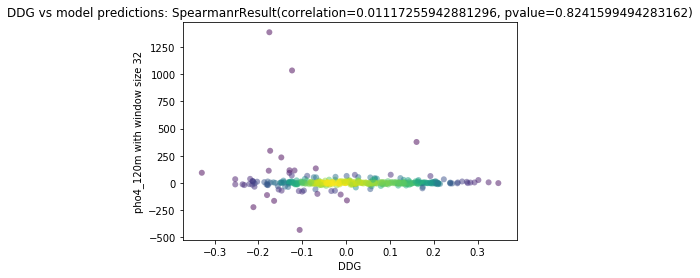

pho4_30m


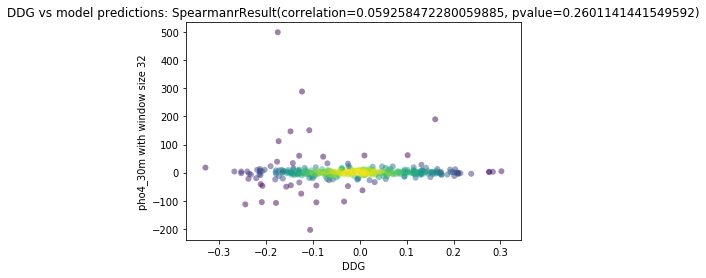

pho4_pbexo


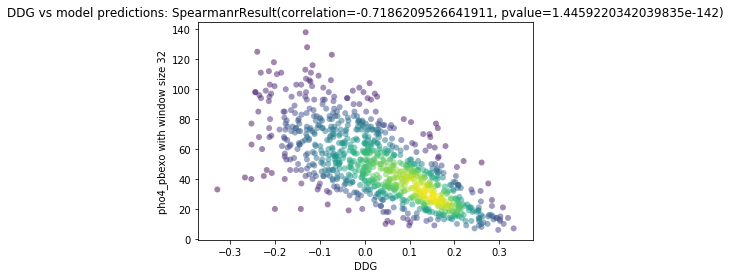

64
pho4_120m


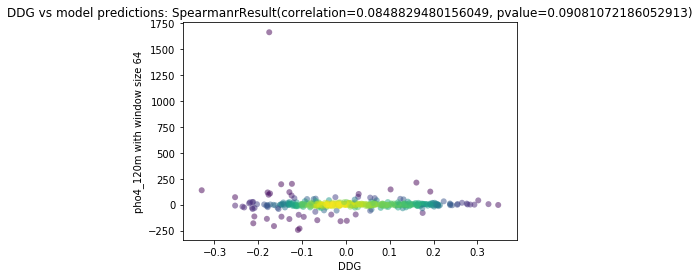

pho4_30m


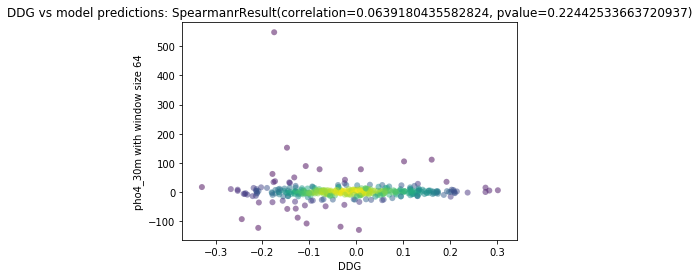

pho4_pbexo


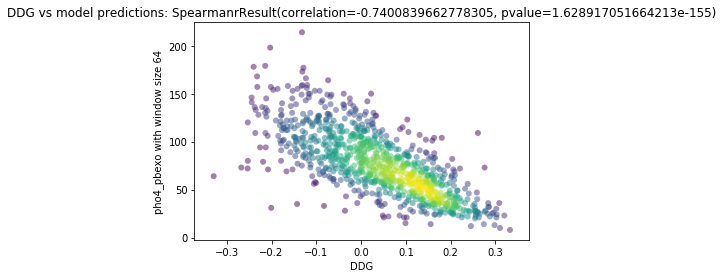

128
pho4_120m


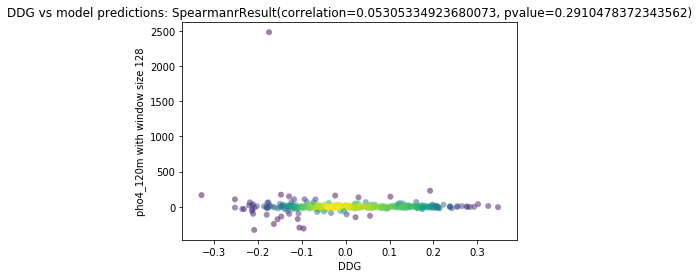

pho4_30m


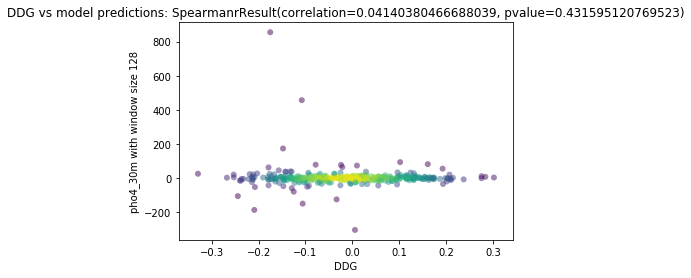

pho4_pbexo


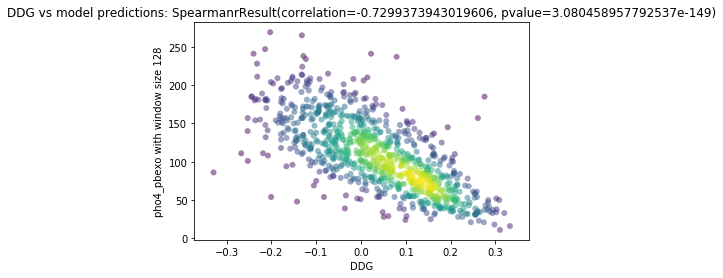

256
pho4_120m


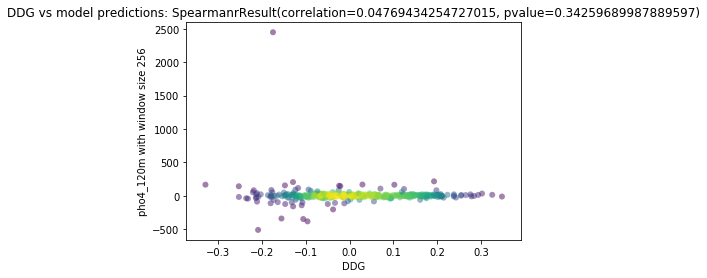

pho4_30m


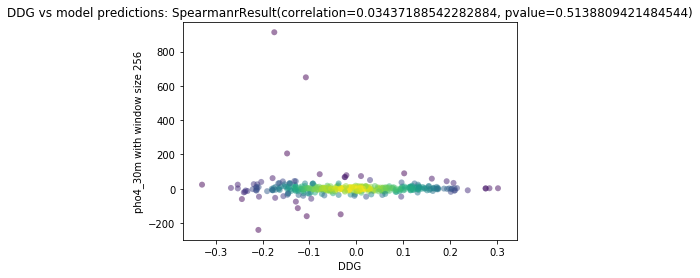

pho4_pbexo


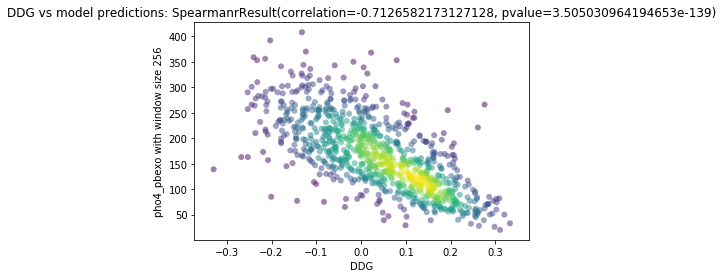

546
pho4_120m


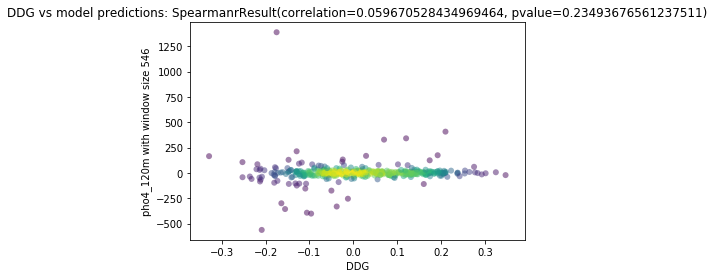

pho4_30m


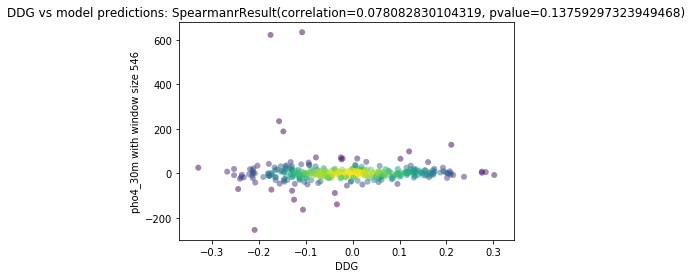

pho4_pbexo


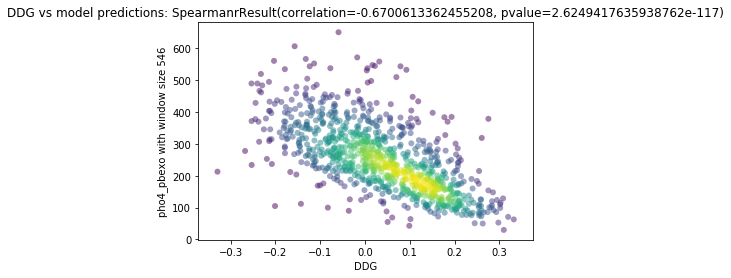

In [12]:
window_sizes = [16, 32, 64, 128, 256, 546]
for window in window_sizes:
    print(window)
    start = int((seq_len/2)-(window/2))
    end = int((seq_len/2)+(window/2))
    for key in tfToBigWigs.keys():
        print(key)
        yvals = []
        for flank in keyToFlankToCoord[key]:
            yvals.append(np.sum(posFootprint[key][flank][start:end]+ \
                                negFootprint[key][flank][start:end]))
        xvals_pho4 = []
        xvals_cbf1 = []
        for flank in keyToFlankToCoord[key]:
            xvals_pho4.append(flankToPho4Ddg[flank])
            xvals_cbf1.append(flankToCbf1Ddg[flank])
        if "pho4" in key:
            xvals = xvals_pho4
        elif "cbf1" in key:
            xvals = xvals_cbf1
        xy = np.vstack([xvals,yvals])
        z = gaussian_kde(xy)(xy)
        smallFont = {'size' : 10}
        plt.rc('font', **smallFont)
        fig, ax = plt.subplots()
        ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
        plt.xlabel("DDG")
        plt.ylabel(key+" with window size "+str(window))
        plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
        plt.show()